In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import EngFormatter
import random
import scipy.stats as stats
import cooler
import os
import math
from scipy.optimize import minimize
import h5py
import pickle
import warnings
import pickle
warnings.filterwarnings('ignore')

In [199]:
def plot_ab(value_list1, value_list2, title, column1=None, column2=None):
    u_stat, p_value = stats.mannwhitneyu(value_list1, value_list2)
    plt.figure(figsize=(4, 3))
    box = plt.boxplot([value_list1, value_list2], labels=[column1, column2], patch_artist=True)
    
    # 设置颜色
    colors = ['#ef8a62', '#67a9cf']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # 设置中间线颜色为黑色
    for median in box['medians']:
        median.set_color('black')
    plt.title(title)
    plt.ylabel("Obs/Exp")
    # 不显示上边框和右边框
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # 在图上添加 p 值
    x1, x2 = 1, 2  # 两组数据的位置
    y, h, col = max(max(value_list1), max(value_list2))+0.05, 0.1, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    
    # 判断显著性
    if p_value > 0.05:
        significance = "ns"
    elif 0.01 < p_value <= 0.05:
        significance = "*"
    elif 0.001 < p_value <= 0.01:
        significance = "**"
    elif 0.0001 < p_value <= 0.001:
        significance = "***"
    elif p_value <= 0.0001:
        significance = "****"
    
    plt.text((x1+x2)*.5, y+h, significance, ha='center', va='bottom', color=col)
    plt.show()


    
def get_start_end(position, df_all_window, df_tad_chr):
    # print(position)
    start_pos = df_all_window.loc[df_all_window['idx_genome'] == position, 'start'].values[0]
    # print(start_pos)
    tad_end = df_tad_chr.loc[df_tad_chr['start'] == start_pos, 'end'].values[0]
    return start_pos, tad_end
import cooler
def psDataFromMat(matrix, indices=None, log_bins=True, base=1.1):
    
    n = min(matrix.shape)
    included_bins = np.zeros(n, dtype=bool)
    if indices is None:
        included_bins[:] = True
    else:
        included_bins[indices] = True
    D = np.array(
        [
            np.average(matrix.diagonal(j)[included_bins[: n - j]])
            for j in range(n)
        ]
    )
    if not log_bins:
        return np.array(range(len(D))), D
    else:
        n_bins = int(np.log(n) / np.log(base) + 1)
        logbin = np.unique(
            np.logspace(0, n_bins - 1, num=n_bins, base=base, dtype=np.int)
        )
        logbin = np.insert(logbin, 0, 0)
        logbin[-1] = min(n, logbin[-1])
        if n < logbin.shape[0]:
            print("Not enough bins. Increase logarithm base.")
            return np.array(range(len(D))), D
        logD = np.array(
            [
                np.average(D[logbin[i - 1] : logbin[i]])
                for i in range(1, len(logbin))
            ]
        )
        return logbin[:-1], logD


def getOEMatrix(matrix:np.ndarray)->np.ndarray:
    """
    get decay profile normalized pearson correlation matrix
    """
    n=matrix.shape[0]
    dist_matrix = np.zeros((n, n))
    _, dist_vals = psDataFromMat(matrix, log_bins=False)
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = dist_vals[abs(j - i)]
    
    #obs/exp = obs / exp
    matrix = matrix / dist_matrix
    
    return matrix

In [3]:
#bin file
resolution = 40000
ref = "mm9"
df_mm = pd.read_csv(f"/shareb/mliu/HiMulti/ref_data/{ref}.chrom.sizes",sep="\t",header=None)
df_mm.columns = ['chrom','size']
df_mm = df_mm.query("chrom!='chrX' and chrom != 'chrY'")


bins = []
for index, row in df_mm.iterrows():
    chrom = row['chrom']
    size = row['size']
    for start in range(0, size, resolution):
        stop = min(start + resolution, size)
        pos = (start + stop) // 2
        bins.append([chrom, start, stop, pos])

# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
bin_table_df_mat = bin_table_df.copy()
bin_table_df_mat['chrom'] = bin_table_df_mat['chrom'].apply(lambda x: x+"(mat)")
bin_table_df_pat = bin_table_df.copy()
bin_table_df_pat['chrom'] = bin_table_df_pat['chrom'].apply(lambda x: x+"(pat)")
df_bin_mm9_40kb = pd.concat([bin_table_df_mat,bin_table_df_pat],axis=0)
df_bin_mm9_40kb.index = range(len(df_bin_mm9_40kb))


# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
chr_list = list(bin_table_df['chrom'].unique())

In [56]:
#读取gam的作为真集
df_all_gam1 = pd.read_csv("/share/home/mliu/shareb/mliu/HiMulti/data/GAM_TAD_pi3.csv")
df_all_gam1['chr1'] = df_all_gam1['tad_x'].apply(lambda x: x.split(":")[0])
df_all_gam1['start1'] = df_all_gam1['tad_x'].apply(lambda x: int(x.split(":")[1].split("-")[0]))
df_all_gam1['end1'] = df_all_gam1['tad_x'].apply(lambda x: int(x.split(":")[1].split("-")[1]))
df_all_gam1['mid1'] = (df_all_gam1['start1']+df_all_gam1['end1'])//2
df_all_gam1['chr2'] = df_all_gam1['tad_y'].apply(lambda x: x.split(":")[0])
df_all_gam1['start2'] = df_all_gam1['tad_y'].apply(lambda x: int(x.split(":")[1].split("-")[0]))
df_all_gam1['end2'] = df_all_gam1['tad_y'].apply(lambda x: int(x.split(":")[1].split("-")[1]))
df_all_gam1['mid2'] = (df_all_gam1['start2']+df_all_gam1['end2'])//2
df_all_gam1['chr3'] = df_all_gam1['tad_z'].apply(lambda x: x.split(":")[0])

df_all_gam1['start3'] = df_all_gam1['tad_z'].apply(lambda x: int(x.split(":")[1].split("-")[0]))
df_all_gam1['end3'] = df_all_gam1['tad_z'].apply(lambda x: int(x.split(":")[1].split("-")[1]))
df_all_gam1['mid3'] = (df_all_gam1['start3']+df_all_gam1['end3'])//2
df_all_gam1['cluster_name'] = df_all_gam1.apply(lambda row: f"{row['chr1']}:{row['start1']}-{row['end1']};{row['chr2']}:{row['start2']}-{row['end2']};{row['chr3']}:{row['start3']}-{row['end3']};", axis=1)

df_all_gam1['distance1'] = np.abs(df_all_gam1['mid1']-df_all_gam1['mid2'])
df_all_gam1['distance2'] = np.abs(df_all_gam1['mid3']-df_all_gam1['mid2'])
df_all_gam1['distance3'] = np.abs(df_all_gam1['mid3']-df_all_gam1['mid1'])

df_all_gam1['start1_idx'] = df_all_gam1['start1'] // resolution
df_all_gam1['end1_idx'] = df_all_gam1['end1'] // resolution
df_all_gam1['start2_idx'] = df_all_gam1['start2'] // resolution
df_all_gam1['end2_idx'] = df_all_gam1['end2'] // resolution
df_all_gam1['start3_idx'] = df_all_gam1['start3'] // resolution
df_all_gam1['end3_idx'] = df_all_gam1['end3'] // resolution


df_all_gam1_top = df_all_gam1.head(int(len(df_all_gam1)*0.01))


In [49]:
df_all_window = pd.read_csv("/share/home/mliu/shareb/mliu/HiMulti/multiplex-gam-2023/data/raw/40kb_windows_named.bed",sep="\t",header=None)
df_all_window.columns = ['chr','start','end','window']
df_all_window['idx_genome'] = df_all_window['window'].apply(lambda x: int(x.split("_")[1])-1)

df_tad = pd.read_csv("/share/home/mliu/shareb/mliu/HiMulti/data/tads_by_se_and_groseq.csv")
df_tad['chr'] = df_tad['tad'].apply(lambda x: x.split(":")[0])
df_tad['start'] = df_tad['tad'].apply(lambda x: int(x.split(":")[1].split("-")[0]))
df_tad['end'] = df_tad['tad'].apply(lambda x: int(x.split(":")[1].split("-")[1]))
df_tad['mid'] = (df_tad['start'] + df_tad['end']) // 2
df_tad['size'] = (df_tad['end'] - df_tad['start']) // 40000



In [148]:

gam_set = set()
df_gam_common = pd.DataFrame(columns=['cluster_name','triplet_score','chr1','start1','end1','start2','end2','start3','end3'])
for chr in chr_list[1:]:
    print(chr)
    df_gam2_triplet_chr = pd.read_csv(f"/share/home/mliu/shareb/mliu/HiMulti/multiplex-gam-2023/data/raw/slice-output/triplets/pi_triplets_tads_{chr}.out",sep="\t",comment="#")
    df_gam2_triplet_chr = df_gam2_triplet_chr.sort_values(by=" Avg_pi_triplet",ascending=False)
    df_gam2_triplet_chr['chr'] = chr
    df_gam2_triplet_chr.index = range(len(df_gam2_triplet_chr))
    df_gam2_triplet_chr = df_gam2_triplet_chr.head(3000)

    df_tad_chr = df_tad[df_tad['chr']==chr]
    df_gam2_triplet_chr['start1'], df_gam2_triplet_chr['end1'] = zip(*df_gam2_triplet_chr['Position_tad_A'].apply(lambda x: get_start_end(x, df_all_window, df_tad_chr)))
    df_gam2_triplet_chr['start2'], df_gam2_triplet_chr['end2'] = zip(*df_gam2_triplet_chr[' Position_tad_B'].apply(lambda x: get_start_end(x, df_all_window, df_tad_chr)))
    df_gam2_triplet_chr['start3'], df_gam2_triplet_chr['end3'] = zip(*df_gam2_triplet_chr[' Position_tad_C'].apply(lambda x: get_start_end(x, df_all_window, df_tad_chr)))
    df_gam2_triplet_chr['cluster_name'] =  df_gam2_triplet_chr.apply(lambda row: f"{row['chr']}:{row['start1']}-{row['end1']};{row['chr']}:{row['start2']}-{row['end2']};{row['chr']}:{row['start3']}-{row['end3']};", axis=1)
    set2 = set(df_gam2_triplet_chr['cluster_name'])

    
    df_all_gam1_chr = df_all_gam1.query("chr1==@chr")
    df_all_gam1_chr_top = df_all_gam1_chr.head(3000)
    set1 = set(df_all_gam1_chr_top['cluster_name'])

    set_all = set1.union(set2)
    #添加到gam_set中
    gam_set = gam_set.union(set_all)
    
    set_common = set1.intersection(set2)
    df_gam_common_chr = df_all_gam1_chr_top[df_all_gam1_chr_top['cluster_name'].isin(set_common)][['cluster_name','triplet_score','chr1','start1','end1','start2','end2','start3','end3']]
    df_gam_common = pd.concat([df_gam_common,df_gam_common_chr],axis=0)
df_gam_common.index = range(len(df_gam_common))


chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19


In [110]:
# df_gam_common = df_gam_common.sort_values(by="triplet_score",ascending=False)
# df_gam_common.to_csv("common_gam_triplet.csv",index=False)

In [149]:
len(gam_set)

85887

## hic

In [114]:
#读bulk hic
clr = cooler.Cooler("/shareb/mliu/HiMulti/data/public_hic/mESC_HindIII_ori_40kb.cool")

In [171]:
df_hic = pd.DataFrame(columns=['chr','start1','end1','start2','end2','start3','end3','hic_oe_score'])
for chr in chr_list:
    print(chr)
    chr_matrix = clr.matrix(balance=False).fetch(chr)
    OEmatrix = getOEMatrix(chr_matrix)
    # OEmatrix = chr_matrix
    df_combinations = pd.read_csv(f"../call_multi/tad_combine_{chr}.csv")
    df_combinations['index_start1'] = df_combinations['start1']//40000
    df_combinations['index_end1'] = df_combinations['end1']//40000
    df_combinations['index_start2'] = df_combinations['start2']//40000
    df_combinations['index_end2'] = df_combinations['end2']//40000
    df_combinations['index_start3'] = df_combinations['start3']//40000
    df_combinations['index_end3'] = df_combinations['end3']//40000
    def calculate_hic_score(row):
        # print("mat.shape",mat.shape)
        contacts_xy = np.nanmean(OEmatrix[row['index_start1']:row['index_end1'], row['index_start2']:row['index_end2']])
        contacts_xz = np.nanmean(OEmatrix[row['index_start1']:row['index_end1'], row['index_start3']:row['index_end3']])
        contacts_yz = np.nanmean(OEmatrix[row['index_start2']:row['index_end2'], row['index_start3']:row['index_end3']])
        return min(contacts_xy, contacts_xz, contacts_yz)
    df_combinations['hic_oe_score'] = df_combinations.apply(calculate_hic_score, axis=1)
    #按照hic_oe_score从大到小排序
    df_combinations = df_combinations.sort_values(by='hic_oe_score', ascending=False)
    df_combinations_top = df_combinations.head(int(len(df_combinations)*0.01))[['chr','start1','end1','start2','end2','start3','end3','hic_oe_score']]
    df_combinations_top.index = range(len(df_combinations_top))
    df_hic = pd.concat([df_hic,df_combinations_top],axis=0)
    

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19


In [172]:
df_hic = df_hic.sort_values(by='hic_oe_score', ascending=False)
df_hic['cluster_name'] = df_hic.apply(lambda row: f"{row['chr']}:{row['start1']}-{row['end1']};{row['chr']}:{row['start2']}-{row['end2']};{row['chr']}:{row['start3']}-{row['end3']};", axis=1)

In [173]:

print(len(df_gam_common))
df_hic = df_hic.head(len(df_gam_common))
df_trans = df_hic.query("cluster_name not in @gam_set")
print(len(df_trans))
df_trans.index = range(len(df_trans))


11652
10855


In [174]:
df_trans

,chr,start1,end1,start2,end2,start3,end3,hic_oe_score,cluster_name
0,chr7,25160000,25800000,87120000,87480000,133320000,134400000,4.246167,chr7:25160000-25800000;chr7:87120000-87480000;...
1,chr7,35560000,36440000,87120000,87480000,133320000,134400000,4.196170,chr7:35560000-36440000;chr7:87120000-87480000;...
2,chr7,52960000,53880000,107160000,107640000,150280000,150720000,4.177081,chr7:52960000-53880000;chr7:107160000-10764000...
3,chr7,35560000,36440000,107160000,107640000,150280000,150720000,4.177081,chr7:35560000-36440000;chr7:107160000-10764000...
4,chr7,30320000,31080000,107160000,107640000,150280000,150720000,4.177081,chr7:30320000-31080000;chr7:107160000-10764000...
...,...,...,...,...,...,...,...,...,...
10850,chr7,56000000,56720000,86240000,86520000,149920000,150280000,2.253804,chr7:56000000-56720000;chr7:86240000-86520000;...
10851,chr7,35560000,36440000,86240000,86520000,149920000,150280000,2.253804,chr7:35560000-36440000;chr7:86240000-86520000;...
10852,chr7,16480000,17520000,86240000,86520000,149920000,150280000,2.253804,chr7:16480000-17520000;chr7:86240000-86520000;...
10853,chr7,72840000,73240000,86240000,86520000,149920000,150280000,2.253804,chr7:72840000-73240000;chr7:86240000-86520000;...


In [175]:
#gam_set - hic_set
df_trans.head(234).to_csv("trans_hic.csv",index=False)

## plotAB

In [163]:

with open("all_gam_spatial_distance_circle_list.pickle", 'rb') as file:
    gam_spatial_distance_circle_list = pickle.load(file)
    gam_spatial_distance_circle_list =  [item for sublist in gam_spatial_distance_circle_list for item in sublist]

with open("all_gam_spatial_distance_max_list.pickle","rb") as file:
    gam_spatial_distance_max_list = pickle.load(file)
    gam_spatial_distance_max_list =  [item for sublist in gam_spatial_distance_max_list for item in sublist]

with open("all_gam_spatial_distance_mean_list.pickle","rb") as file:
    gam_spatial_distance_mean_list = pickle.load(file)
    gam_spatial_distance_mean_list =  [item for sublist in gam_spatial_distance_mean_list for item in sublist]

with open("all_gam_hic_list.pickle","rb") as file:
    gam_hic_list = pickle.load(file)
    gam_hic_list =  [item for sublist in gam_hic_list for item in sublist]


with open("all_gam_spatial_distance_circle_random_bg_list.pickle", 'rb') as file:
    gam_spatial_distance_circle_random_bg_list = pickle.load(file)
    gam_spatial_distance_circle_random_bg_list =  [item for sublist in gam_spatial_distance_circle_random_bg_list for item in sublist]

with open("all_gam_spatial_distance_max_random_bg_list.pickle","rb") as file:
    gam_spatial_distance_max_random_bg_list = pickle.load(file)
    gam_spatial_distance_max_random_bg_list =  [item for sublist in gam_spatial_distance_max_random_bg_list for item in sublist]

with open("all_gam_spatial_distance_mean_random_bg_list.pickle","rb") as file:
    gam_spatial_distance_mean_random_bg_list = pickle.load(file)
    gam_spatial_distance_mean_random_bg_list =  [item for sublist in gam_spatial_distance_mean_random_bg_list for item in sublist]

with open("all_gam_hic_random_bg_list.pickle","rb") as file:
    gam_hic_random_bg_list = pickle.load(file)
    gam_hic_random_bg_list =  [item for sublist in gam_hic_random_bg_list for item in sublist]

In [176]:

with open("all_hic_spatial_distance_circle_list.pickle", 'rb') as file:
    hic_spatial_distance_circle_list = pickle.load(file)
    hic_spatial_distance_circle_list =  [item for sublist in hic_spatial_distance_circle_list for item in sublist]

with open("all_hic_spatial_distance_max_list.pickle","rb") as file:
    hic_spatial_distance_max_list = pickle.load(file)
    hic_spatial_distance_max_list =  [item for sublist in hic_spatial_distance_max_list for item in sublist]

with open("all_hic_spatial_distance_mean_list.pickle","rb") as file:
    hic_spatial_distance_mean_list = pickle.load(file)
    hic_spatial_distance_mean_list =  [item for sublist in hic_spatial_distance_mean_list for item in sublist]

with open("all_hic_hic_list.pickle","rb") as file:
    hic_hic_list = pickle.load(file)
    hic_hic_list =  [item for sublist in hic_hic_list for item in sublist]


with open("all_hic_spatial_distance_circle_random_bg_list.pickle", 'rb') as file:
    hic_spatial_distance_circle_random_bg_list = pickle.load(file)
    hic_spatial_distance_circle_random_bg_list =  [item for sublist in hic_spatial_distance_circle_random_bg_list for item in sublist]

with open("all_hic_spatial_distance_mean_random_bg_list.pickle","rb") as file:
    hic_spatial_distance_mean_random_bg_list = pickle.load(file)
    hic_spatial_distance_mean_random_bg_list =  [item for sublist in hic_spatial_distance_mean_random_bg_list for item in sublist]

with open("all_hic_spatial_distance_max_random_bg_list.pickle","rb") as file:
    hic_spatial_distance_max_random_bg_list = pickle.load(file)
    hic_spatial_distance_max_random_bg_list =  [item for sublist in hic_spatial_distance_max_random_bg_list for item in sublist]

with open("all_hic_hic_random_bg_list.pickle","rb") as file:
    hic_hic_random_bg_list = pickle.load(file)
    hic_hic_random_bg_list =  [item for sublist in hic_hic_random_bg_list for item in sublist]

In [201]:
hic_ratio = [
        circle / random_bg
        for circle, random_bg in zip(hic_spatial_distance_max_list, hic_spatial_distance_max_random_bg_list)
    ]
gam_ratio = [
        circle / random_bg
        for circle, random_bg in zip(gam_spatial_distance_max_list, gam_spatial_distance_max_random_bg_list)
    ]

In [202]:
np.mean(gam_ratio)

0.8726290307275214

In [203]:
np.mean(hic_ratio)

0.978044157032376

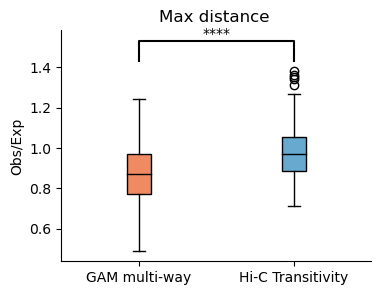

In [205]:
plot_ab(gam_ratio,hic_ratio,"Max distance ","GAM multi-way","Hi-C Transitivity")